### Approach:

I'll be exploring the folder of Kenneth Lay; there are more than 5k emails in this folder only. The dataset contains 150 folders each representing a user, so you can imagine the amount of time and effort exerted trying to go through these emails aimlessly searching for clues and important information.

My goal is to extract and organize specific details from each email i.e.: to, from, cc, bcc, subject and email body; then identify emails that might prove to be beneficial or interesting to be read. So it’s like searching for a needle in a haystack but with a Magnet!

In [1]:
import os
import numpy as np
import pandas as pd
import re
import hashlib
import string
from collections import Counter
from functools import reduce
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import pipeline
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# # setting up pandas display options

# pd.options.display.max_rows = 1000

# # activate to reset display options
# pd.reset_option("^display")

In [2]:
# Data extraction from e-mail text files, same approach can be applied to the rest of the folders 
# as text file structure is almost the same

# folder path, use your own here! 
directory = r'your:path\goes\here\enron_mail_20110402\maildir\lay-k'

# email content (from, to, cc, bcc, subject, hash of email body, etc...)
emails_ = []

# email body for latter summarization
email_body = []

for folder, subfolder, filenames in os.walk(directory):
# #     activate to remove emails in calendar folder, they are basically meeting invitations
#     if 'calendar' in subfolder:
#         subfolder.remove('calendar')

    for filename in filenames:
        path = os.path.join(folder, filename)
        source_folder = path.split('maildir\\')[1]
        with open(path, "r") as email:
            email.seek(0)          # to ensure we're reading the file from the begining
            text = email.read()
            # Extract email details
            search_word = ['Date:', 'From:', 'Subject:']
            split_line = [i for i, line in enumerate(text.splitlines()) for word in search_word if word in line]
            date = re.split('Date:|-', text.splitlines()[split_line[0]])[1]
            from_ = text.splitlines()[split_line[1]].split('From:')[1]
            subject = text.splitlines()[split_line[2]].split('Subject:')[1]
            
            # hashing email body to identify duplicate emails later in the analysis. Can't use email_id from within the
            # text file as duplicate emails have different id.
            # Will split on 'X-FileName' as email body lies after this line; however, line length differ in all emails
            # so regex would be better here than a fixed search word
            content_split_word = re.search(r'X-FileName(.*?)\n', text , re.DOTALL).group()
            email_content = text.split(content_split_word)[-1]
            hashed_content = hashlib.sha256(email_content.encode('utf-8')).hexdigest()
            
            # to, cc and bcc are also not fixed in all emails depending on number of recipients so they may be spread over
            # many lines, again regex is better here
            to = ''
            cc = ''
            bcc = ''
            if re.search(r'To:(.*?)Subject:', text , re.DOTALL):
                to = re.search(r'To:(.*?)Subject:', text , re.DOTALL).group().replace('\n', '').replace('\t', '').\
                replace(' ', '').replace('Subject:', '').split('To:')[1]
            if re.search(r'Cc:(.*?)Mime', text , re.DOTALL):
                cc = re.search(r'Cc:(.*?)Mime', text , re.DOTALL).group().replace('\n', '').replace('\t', '').\
                replace(' ', '').replace('Mime', '').split('Cc:')[1]
            if re.search(r'Bcc:(.*?)X-From', text , re.DOTALL):
                bcc = re.search(r'Bcc:(.*?)X-From', text , re.DOTALL).group().replace('\n', '').replace('\t', '').\
                replace(' ', '').replace('X-From', '').split('Bcc:')[1]
                
            # append path as well if you want to explore emails within the notebook    
            emails_.append((from_, to, cc, bcc, subject, date, hashed_content, source_folder))
            email_body.append((email_content, source_folder))

In [3]:
# DataFrame for all extracted details

emails_df = pd.DataFrame(emails_, columns=['from_', 'to_', 'cc', 'bcc', 'subject', 'date', 'content_hash', 'source_folder'])

emails_df.date = pd.to_datetime(emails_df.date)

emails_df

,from_,to_,cc,bcc,subject,date,content_hash,source_folder
0,ralph.blakemore@enron.com,"kenneth.lay@enron.com,jeff.skilling@enron.com",,,2000 Chairman's Award,2000-12-08 07:49:00,aaa1f881d4d682d3eb850ab4e5132bd4ea3c79b7ba9514...,lay-k\all_documents\1000_
1,barbara.paige@enron.com,"samantha.bryce@enron.com,adriana.cortes@enron....",,,Field Study Program,2000-12-11 01:52:00,8a1af7897d3e42c286edb1c86cf894158404bfbbbe7637...,lay-k\all_documents\1001_
2,william.ramsay@iea.org,kenneth.lay@enron.com,robert.priddle@iea.org,robert.priddle@iea.org,RE: IEA Ministerial/OECD Ministerial,2000-12-11 09:02:00,5fba26fdb2f5455f4330272027332ce72a4e90033013ac...,lay-k\all_documents\1002_
3,rosalee.fleming@enron.com,shea_dugger@i2.com,,,Re: Final Eagle BOD Presentation,2000-12-11 02:49:00,2795b7cbadb9a64a23ccd7110918740f9dfe542f814b70...,lay-k\all_documents\1003_
4,nancy@newcapitolsolutions.com,kenneth.lay@enron.com,,,Richard's Resume,2000-12-11 04:01:00,bdf5a0296e18a9b8a4b9f7c7ddf3ee2ccc58a545cd2256...,lay-k\all_documents\1004_
...,...,...,...,...,...,...,...,...
5932,rosalee.fleming@enron.com,jwatson@velaw.com,,,Re: v2-term sheet with Rockets.DOC,2000-08-01 07:57:00,aa5b79f55e44c1f27790678671013888d1d486217fdaaa...,lay-k\_sent\96_
5933,tori.wells@enron.com,johnp@energycoaliton.org,,,,2000-08-02 02:09:00,69e5e7e7cf25faf21f03c7d1c2b7ae47d2d1d756beaeee...,lay-k\_sent\97_
5934,tori.wells@enron.com,gene.humphrey@enron.com,,,Health Status,2000-08-03 06:37:00,b79891aec482982dc38def9ac0010bfb429585b782cb9b...,lay-k\_sent\98_
5935,rosalee.fleming@enron.com,rob.bradley@enron.com,tori.wells@enron.com,tori.wells@enron.com,Re: Gathering Place Speaking Invitation,2000-08-04 05:40:00,857e000114f64fbdc78ad0240f4a5a15b7016f0d28a60c...,lay-k\_sent\99_


In [4]:
# checking for duplicate emails based on content hash, as email subject might be duplicated for different emails

emails_df.content_hash.duplicated().sum()

2291

In [5]:
# Display duplicate emails

emails_df[emails_df.content_hash.duplicated(keep=False)].sort_values('content_hash', ascending = False)

,from_,to_,cc,bcc,subject,date,content_hash,source_folder
1001,shea_dugger@i2.com,"bcash@interwest.com,kenneth.lay@enron.com,rome...","jdavidson@srfunds.com,rosalee.fleming@enron.co...","jdavidson@srfunds.com,rosalee.fleming@enron.co...",BOARD OF DIRECTORS CONFERENCE CALL 11/28,2000-11-22 07:08:00,fff4ed90d6f0ac8c3989d2f4fe8f4db801ecce5bca6d97...,lay-k\all_documents\887_
2974,shea_dugger@i2.com,"bcash@interwest.com,kenneth.lay@enron.com,rome...","jdavidson@srfunds.com,rosalee.fleming@enron.co...","jdavidson@srfunds.com,rosalee.fleming@enron.co...",BOARD OF DIRECTORS CONFERENCE CALL 11/28,2000-11-22 07:08:00,fff4ed90d6f0ac8c3989d2f4fe8f4db801ecce5bca6d97...,lay-k\discussion_threads\747_
5206,shea_dugger@i2.com,"bcash@interwest.com,kenneth.lay@enron.com,rome...","jdavidson@srfunds.com,rosalee.fleming@enron.co...","jdavidson@srfunds.com,rosalee.fleming@enron.co...",BOARD OF DIRECTORS CONFERENCE CALL 11/28,2000-11-22 07:08:00,fff4ed90d6f0ac8c3989d2f4fe8f4db801ecce5bca6d97...,lay-k\notes_inbox\658_
5460,rosalee.fleming@enron.com,john.hardy@enron.com,"joseph.sutton@enron.com,cindy.adams@enron.com","joseph.sutton@enron.com,cindy.adams@enron.com","Re: Prospective Meeting with Jim Harmon, Chai...",2000-02-27 09:14:00,ffc2d6f22b9afe76d7c58b62ecec290da46c6f2d6438e0...,lay-k\sent\158_
5762,rosalee.fleming@enron.com,john.hardy@enron.com,"joseph.sutton@enron.com,cindy.adams@enron.com","joseph.sutton@enron.com,cindy.adams@enron.com","Re: Prospective Meeting with Jim Harmon, Chai...",2000-02-27 09:14:00,ffc2d6f22b9afe76d7c58b62ecec290da46c6f2d6438e0...,lay-k\_sent\17_
...,...,...,...,...,...,...,...,...
3157,jeffrey.mcclellan@enron.com,kenneth.lay@enron.com,"tori.wells@enron.com,rosalee.fleming@enron.com","tori.wells@enron.com,rosalee.fleming@enron.com",Thank you,2000-08-31 03:55:00,004467011d007e821eefb1f82410c0d744e25b8eeee1b3...,lay-k\discussion_threads\936_
168,jeffrey.mcclellan@enron.com,kenneth.lay@enron.com,"tori.wells@enron.com,rosalee.fleming@enron.com","tori.wells@enron.com,rosalee.fleming@enron.com",Thank you,2000-08-31 03:55:00,004467011d007e821eefb1f82410c0d744e25b8eeee1b3...,lay-k\all_documents\1328_
5176,karen.denne@enron.com,kenneth.lay@enron.com,"rosalee.fleming@enron.com,tori.wells@enron.com...","rosalee.fleming@enron.com,tori.wells@enron.com...",Continental photo,2000-11-17 06:52:00,00320afb596057f9af0d69cdd8bbc9044a84f31b9cd1d5...,lay-k\notes_inbox\630_
964,karen.denne@enron.com,kenneth.lay@enron.com,"rosalee.fleming@enron.com,tori.wells@enron.com...","rosalee.fleming@enron.com,tori.wells@enron.com...",Continental photo,2000-11-17 06:52:00,00320afb596057f9af0d69cdd8bbc9044a84f31b9cd1d5...,lay-k\all_documents\853_


Out of total 5.9k emails there are 2.2k emails duplicated, mainly because same copy of an email is located in different subfolder

In [6]:
# filtering unique emails based on subject and content

unique_emails = emails_df[~(emails_df.subject.duplicated() & emails_df.content_hash.duplicated())].copy()

unique_emails.sort_values(by= 'subject', ascending=False).head()

,from_,to_,cc,bcc,subject,date,content_hash,source_folder
4392,cannon_craig@yahoo.com,kenneth.lay@enron.com,,,your job,2001-12-04 11:35:15,f14fd535bb3c1d0ff31a077f6a6154d524f746a2e2bd56...,lay-k\inbox\812_
3322,justinsitzman@hotmail.com,kenneth_lay@enron.com,,,you suck,2002-01-17 10:30:35,97be91e539f39b2b615e4904c1e1e00914221fda8b8a3f...,lay-k\inbox\1094_
4333,jparker@dentsply.com,klay@enron.com,,,you,2001-11-30 11:48:41,a10da314f1a5154c0a18027f3a404db1b1f94ac6bb0cf5...,lay-k\inbox\759_
4496,phylis.karas@enron.com,kenneth.lay@enron.com,,,word of support,2001-12-21 11:52:55,da8d174f0ed028c2b6863a10a26d9b842403d195a64876...,lay-k\inbox\907_
3873,kann@pdq.net,kann@pdq.net,,,where to test suspecious letters in Houston?,2001-10-20 13:02:50,d1dff6bdc9439dd119eb660f080db0d007b1a5ccfb973a...,lay-k\inbox\339_


In [10]:
# Account activity overview

from_count = unique_emails.groupby('from_').count().reset_index().sort_values('to_', ascending= False)

from_count.drop(columns = from_count.columns[2:], inplace = True)

from_count.rename(columns = {'to_':'email_count'}, inplace=True)

from_count.head(15)

,from_,email_count
1814,rosalee.fleming@enron.com,262
1589,no.address@enron.com,41
262,brown_mary_jo@lilly.com,36
2019,svarga@kudlow.com,34
1263,leonardo.pacheco@enron.com,26
1528,mrslinda@lplpi.com,26
491,dbrock@howard.edu,24
1876,savont@email.msn.com,22
1102,karen.denne@enron.com,21
608,elizabeth.davis@compaq.com,21


Only 14 emails were sent from the address kenneth.lay@enron.com, maybe because some emails were deleted from the dataset

In [11]:
# Emails that need further inspection, just to understand their context

check_words = 'rosalee|address|lizard|announcements|perfmgmt|beau|enron.announcement|chairman'

check_emails = unique_emails[unique_emails.from_.str.contains(check_words)].sort_values('from_')

check_emails

,from_,to_,cc,bcc,subject,date,content_hash,source_folder
3223,announcements.enron@enron.com,dl-ga-all_enron_houston_employees@enron.com,,,Bus Pass and Parking Information,2002-01-10 07:22:28,1d048bf97eacbe95b4d9d93893dd7bbf2f25df1f25d334...,lay-k\inbox\1002_
3315,announcements.enron@enron.com,"dl-ga-all_ees@enron.com,dl-ga-all_enron_north_...",,,NETCO Employees at Enron,2002-01-16 16:15:47,48361d744601573460d65465a13ceda3488b71f43374fe...,lay-k\inbox\1088_
3300,announcements.enron@enron.com,dl-ga-all_enron_north_america@enron.com,,,2002 Holiday Schedule,2002-01-15 17:12:58,f6f5bac2d40d1a27ce170f88dcf1387421c203ef10af03...,lay-k\inbox\1074_
3282,announcements.enron@enron.com,dl-ga-all_enron_houston@enron.com,,,KOMP Horticultural - Sale of Leased Plants,2002-01-15 07:06:12,f8f69473ece0632a741967c49915eef29f1095a0b448b6...,lay-k\inbox\1058_
3228,announcements.enron@enron.com,dl-ga-all_enron_houston@enron.com,,,Update to Bus Pass Information,2002-01-10 09:34:18,79181e3e51c27c71e01e0fbccaf30feca2e6423ea3262c...,lay-k\inbox\1008_
...,...,...,...,...,...,...,...,...
173,rosalee.fleming@enron.com,lizard_ar@yahoo.com,,,Re: Resume 2,2000-06-21 06:41:00,5cac0c8e9016b7391222b7cb691b63d58c185c5238800b...,lay-k\all_documents\133_
165,rosalee.fleming@enron.com,godwin.carmona@aspeninstitute.org,,,Re: Materials for Aspen ISIB's Business Leade...,2000-06-21 01:35:00,c794b3f1667cbebaf2531f7ecf4428726014436a590ece...,lay-k\all_documents\130_
163,rosalee.fleming@enron.com,mrslinda@lplpi.com,,,VIP Reception and Photo Op,2000-06-20 11:00:00,f8169b88696ff59901678c75a4c80a01b26a69a128da64...,lay-k\all_documents\129_
161,rosalee.fleming@enron.com,katherine.brown@enron.com,,,"Re: EXECUTIVE COMMITTEE MEETING - MONDAY, JUN...",2000-06-20 06:26:00,038f30556de2e580105c29e302991c1a87c4c8ad7b679a...,lay-k\all_documents\127_


Going through some of these e-mails, it was noted that:

- no.address@enron.com does contain a mixture of e-mails sent from different parties, this was identified from the *X-From:* section in the original e-mail file and could be explored further but I won't be covering this here. However, key point to note is that several different e-mails were used to send messages on lay's behalf, examples: chairman.enron@enron.com, chairman.ken@enron.com, chairman.office@enron.com, officeofthechairman2@enron.com, chairman.enron@enron.com and rosalee.fleming@enron.com.

In [12]:
# Other emails in lay's folder, not sent or received from/by his obvious email addresses

k_lay_emails = unique_emails[(unique_emails.from_.str.contains('kenneth.lay@enron.com|klay@enron.com')) |
                             (unique_emails.to_.str.contains('kenneth.lay@enron.com|klay@enron.com')) | 
                             (unique_emails.cc.str.contains('kenneth.lay@enron.com|klay@enron.com')) |
                             (unique_emails.bcc.str.contains('kenneth.lay@enron.com|klay@enron.com'))] 

k_lay_realted_emails = unique_emails[~unique_emails.index.isin(k_lay_emails.index)]

k_lay_realted_emails

,from_,to_,cc,bcc,subject,date,content_hash,source_folder
3,rosalee.fleming@enron.com,shea_dugger@i2.com,,,Re: Final Eagle BOD Presentation,2000-12-11 02:49:00,2795b7cbadb9a64a23ccd7110918740f9dfe542f814b70...,lay-k\all_documents\1003_
5,rosalee.fleming@enron.com,kevin.hannon@enron.com,"sherri.sera@enron.com,carol.brown@enron.com","sherri.sera@enron.com,carol.brown@enron.com",Re: Cornell,2000-12-11 06:39:00,c5de36dc178f3f83e7d7e95e8a822e3340bd7bda223fac...,lay-k\all_documents\1005_
6,rosalee.fleming@enron.com,kelly.merritt@enron.com,,,Re: Advertising Campaign - NASCAR,2000-12-11 09:04:00,4fd51bb06346b5c6f838d56b6ed18a82deb66f8de1709c...,lay-k\all_documents\1006_
9,elizabeth.davis@compaq.com,houirtreas@compaq.com,,,Financial Analysts' Reports for 12.12.00,2000-12-12 00:56:00,12d855645fcfffcd81f5bbb0c4e90be4930448ff8bb47c...,lay-k\all_documents\1009_
12,david.sir.walker@msdw.com,,,,Cocktail Reception in Davos,2000-12-12 07:52:00,8c9e1df25ac73d66777adadba41fa30b1bf5bf799c62ac...,lay-k\all_documents\1011_
...,...,...,...,...,...,...,...,...
4582,kdrouet@molecularelectronics.com,kdrouet@molecularelectronics.com,,,Jack Tompkins,2002-01-09 10:02:08,5e4c9eb0010dfc4a6a7c8d6f6801958549d40fb406b8d4...,lay-k\inbox\988_
4583,chairman.enron@enron.com,dl-ga-all_enron_houston_employees@enron.com,,,"Coffee & Donuts, Friday 8:00 - 9:00 a.m.",2002-01-09 10:40:59,53eb64f6bf953e9215bb2dccb00f66f9a1b704658c9c67...,lay-k\inbox\989_
4592,schedule@clayfarmer.com,info@clayfarmer.com,,,Clay Farmer Newsletter,2002-01-09 16:04:33,2c7ccff598dcc2454c5d76e925aae58a4fcdf7f4e2f94f...,lay-k\inbox\997_
4594,ldumdum@ase.org,"dnorland@ase.org,crussell@ase.org",,,Industry Policy Task Force Meeting - May 24,2001-05-21 11:15:45,4d5aed9b1b54ca6db1611e2a3e6aa2727efc7874eb4a11...,lay-k\inbox\9_


In [13]:
# Individuals who received frequent emails from lay, using lay's obvious e-mail addresses

from_lay = unique_emails[unique_emails.from_.str.contains('kenneth.lay@enron.com|klay@enron.com')]

to_splitted = from_lay.to_.str.split(',').explode()

to_count = Counter(to_splitted)

lay_from_df = pd.DataFrame.from_dict(to_count, orient='index').reset_index().rename(columns = {'index':'from_lay_to', 
                                                                                               0:'email_count'}).\
sort_values('email_count', ascending = False)

lay_from_df.head()

,from_lay_to,email_count
437,l..wells@enron.com,7
471,k..allen@enron.com,5
571,tim.belden@enron.com,4
581,david.duran@enron.com,4
482,joseph.deffner@enron.com,4


In [14]:
# Individuals who frequently appeared in communications along with lay

to_lay = unique_emails[(unique_emails.to_.str.contains('kenneth.lay@enron.com|klay@enron.com')) | 
                       (unique_emails.cc.str.contains('kenneth.lay@enron.com|klay@enron.com')) |
                       (unique_emails.bcc.str.contains('kenneth.lay@enron.com|klay@enron.com'))] 

to_splitted_ = to_lay.to_.str.split(',').explode()

to_count_ = Counter(to_splitted_)

lay_to_df = pd.DataFrame.from_dict(to_count_, orient='index').reset_index().rename(columns = {'index':'from_x_to_lay_and', 
                                                                                              0:'email_count'}).\
sort_values('email_count', ascending = False)

lay_to_df.head()

,from_x_to_lay_and,email_count
81,klay@enron.com,1499
0,kenneth.lay@enron.com,1212
22,greg.whalley@enron.com,159
46,mark.frevert@enron.com,149
49,mark.koenig@enron.com,143


It’s strange that klay@enron.com recieved 1499 e-mails but sent none. However, as noted earlier some emails are removed from this dataset.

In [15]:
# Individuals who frequently send emails to lay

mask = to_lay.groupby('from_').count().reset_index().sort_values('to_', ascending= False)

mask.drop(columns = mask.columns[2:], inplace = True)

mask.rename(columns = {'from_': 'from_x_to_lay', 'to_':'email_count'}, inplace=True)

mask.head()

,from_x_to_lay,email_count
1166,leonardo.pacheco@enron.com,26
242,brown_mary_jo@lilly.com,23
1418,mrslinda@lplpi.com,22
1738,savont@email.msn.com,22
1019,karen.denne@enron.com,21


In [16]:
# Sampling based on e-mail subject i.e.: search for keywords of particular interest to further inspect related emails.

# DataFrame of emails having no subject for latter analysis
no_subject_df = unique_emails[unique_emails.subject.str.len() <= 1]

email_subject = []

for subject in unique_emails[~unique_emails.index.isin(no_subject_df.index)].subject:
    subject_string = subject.translate(str.maketrans('', '', string.punctuation))
    # Remove recurring words
    subject_string = re.sub(r'\bRE\b|\bRe\b|\bFw\b|\bFwd\b|\bFW\b', '',subject_string).strip()
#     # activate to stem words
#     stemmer = SnowballStemmer("english")
#     subject_string_stem = ' '.join([stemmer.stem(word) for word in subject_string.split()])
#     email_subject.append(subject_string_stem)
    email_subject.append(subject_string)      # deactivate if you choose to stem words

# Tokenize and fill the bag of words with email subject using ngrams of size 1
vectorizer = TfidfVectorizer(stop_words="english")
bag_words = vectorizer.fit_transform(email_subject)

vec = CountVectorizer(stop_words='english')
bow = vec.fit_transform(email_subject)

#### Stemming:

Stemming is to have single representation of each related word i.e.: words like 'responsibility, responsible' would be stemmed as 'response'

It’s better to stem words before creating the bag of words; However, I'll not be stemming words as I need to examine the exact meaning of each word to decide if it would be interesting to explore further or not.

#### TFIDF vectorization:

TFIDF vectorizer rates rare words more highly than common words; this means that words that appear less frequently in the 
subject line of email corpus will be highly rated than frequently used words. So we will obtain two stats for each word in the email subject, one will be the count and the other will be weight of the word. Count will help us determine common topics and weight will help in identifying words that might be of interest to us.

we can use only one TFIDF vectorizer and conclude that low weighted words are less frequent but I like to see both number and weight for each word.

In [17]:
# DataFrame for words' count and weight

word_df = pd.DataFrame(vec.vocabulary_, index=['word_index']).T.reset_index().rename(columns= {'index': 'word'})

data_count = [bow.indices, bow.data]

data_weight = [bag_words.indices, bag_words.data]

word_count_df = pd.DataFrame(data_count).T.rename(columns= {0:'word_index', 1:'word_count'})

word_weight_df = pd.DataFrame(data_weight).T.rename(columns= {0:'word_index', 1:'word_weight'})

# I'll group on max weight as it gives better representation of the word importance regardless of prevalence in each doc.
dfs = [word_df, word_count_df.groupby('word_index').sum(), word_weight_df.groupby('word_index').max()]

word_df = reduce(lambda left, right: pd.merge(left, right, on=['word_index'], how='left'), dfs)

In [18]:
# Simple example of what is going on under the hood during tokenization

l = ['new york city', 're: invitation to isb dinner on may 16, 2000 in new york']

vt = TfidfVectorizer(stop_words="english")
bt = vt.fit_transform(l)

print(bt, '\n', vt.get_feature_names(), '\n', vt.vocabulary_)

  (0, 2)	0.7049094889309326
  (0, 7)	0.5015489070943787
  (0, 6)	0.5015489070943787
  (1, 1)	0.4078241041497786
  (1, 0)	0.4078241041497786
  (1, 3)	0.4078241041497786
  (1, 5)	0.4078241041497786
  (1, 4)	0.4078241041497786
  (1, 7)	0.29017020899133733
  (1, 6)	0.29017020899133733 
 ['16', '2000', 'city', 'dinner', 'invitation', 'isb', 'new', 'york'] 
 {'new': 6, 'york': 7, 'city': 2, 'invitation': 4, 'isb': 5, 'dinner': 3, '16': 0, '2000': 1}


To further explain grouping using max weight, consider the example above:

- (0,7) means: in the first sentence 'new york city' (index 0 in the list 'l'), the word 'york' (index 7 in vectorizer features) is weighted .50

- (1,7) well, u should know by now! 'york' is weighted .29
 
The word 'york' is weighted higher in sentence # 1 than in sentence # 2. Grouping on average will decrease such weight and let's say I’ll filter words above specific threshold to inspect related e-mails, if the average is below filter threshold then such emails will be filtered out while in fact I'd be interested in knowing the contents of such e-mails.

Moreover, if a word weight was significant at least once regardless of recurrence, then it might be meaningful and interesting to further inspect.

In [25]:
# Switch sorting between word_count and word_weight, you can decrease the number of words by 
# eleminating some words before tokenization

word_df.sort_values('word_weight', ascending= False).head(15)

,word,word_index,word_count,word_weight
1515,whats,2896,13,1.0
692,website,2884,2,1.0
2584,reply,2288,3,1.0
222,decision,850,2,1.0
1490,intangibles,1429,1,1.0
2575,ansix341968qpatrioticbigecaf3f,312,1,1.0
2559,unreal,2781,2,1.0
2544,receiving,2223,1,1.0
237,employee,1011,22,1.0
484,thanks,2691,11,1.0


In [23]:
# Filter emails having specific desired word

unique_emails.subject = unique_emails.subject.str.lower()

unique_emails[unique_emails.subject.str.contains('confidential')]

,from_,to_,cc,bcc,subject,date,content_hash,source_folder
114,rosalee.fleming@enron.com,wanda.holloway@compaq.com,,,re: confidential: hr committee approval reque...,2001-04-25 08:27:00,2aa11a78a908809a1b37909accd53999aba439610615cf...,lay-k\all_documents\1105_
621,wanda.holloway@compaq.com,"lawrence.t.babbio.jr@verizon.com,lynnj@iname.c...",linda.auwers@compaq.com,linda.auwers@compaq.com,confidential: materials for friday morning co...,2000-10-11 11:30:00,8165b1148e5af88be2e4c683cd59d6ebf058af10eec70c...,lay-k\all_documents\542_
3243,davidtaylorsf@aol.com,kenneth.lay@enron.com,,,nxe energy cnrs (french agency) confidential ...,2002-01-10 21:23:20,75b04a9e8c6878211061847913250e87f22b43fd8e007c...,lay-k\inbox\1021_
3838,diana.peters@enron.com,kenneth.lay@enron.com,,,confidential,2001-10-23 11:26:48,23558d6b02c3f06d264aa3c5257fca8b036c06100584ab...,lay-k\inbox\307_
4126,andy.blanchard@enron.com,"chairman.office@enron.com,kenneth.lay@enron.co...",,,private & confidential,2001-09-26 11:44:50,c830ad106bfefc3bd08665b5d8d02a32f3905c52215bef...,lay-k\inbox\571_
4145,theresa.connor-smith@enron.com,kenneth.lay@enron.com,,,confidential question,2001-09-25 10:35:20,c599206d8b6e79225543b1adb12be2ed298dfcd403b0c1...,lay-k\inbox\589_
4299,jgedwards@hotmail.com,kennethlay@enron.com,klay@enron.com,klay@enron.com,personal & confidential,2001-11-29 09:46:14,31aaa17ae2e1720f5f1d5b92fbfa3083e71d511e732edd...,lay-k\inbox\728_


In [26]:
# Emails written on behalf of Lay, regardless of sent email address.
# will be inspecting emails sent by Rosalee, Lay's executive assistant.

from_rosalee = unique_emails[unique_emails.from_.str.contains('rosalee.fleming@enron.com')]

mixed_emails = []

for name, folder in [("ken", from_lay.source_folder.to_list()), ("rosalee", from_rosalee.source_folder.to_list())]:
    for email, folder_ in email_body:
        if folder_ in folder :
            # search for first occurrence while prioritizing Rosalee over Ken, this is to avoid instances where an email is
            # signed by Rosalee but the word Ken is in the body of the email
            search_word_a = re.search(r'\brosalee\b|\brosie\b|\brosalee fleming\b', email.lower(), re.DOTALL)
            search_word_b = re.search(r'\bken\b|\bbehalf of\b', email.lower(), re.DOTALL)
            if search_word_a:
                # use 'rossalee' as a unification for signature variants to facilitate filtering later
                mixed_emails.append((name, 'rosalee', folder_))
            elif search_word_b:
                mixed_emails.append((name, search_word_b.group(), folder_))

In [27]:
# DataFrame for mixed emails

mixed_emails_df = pd.DataFrame(mixed_emails, columns=['from_', 'searh_word', 'source_folder'])

mixed_emails_df.head()

,from_,searh_word,source_folder
0,ken,rosalee,lay-k\all_documents\141_
1,ken,ken,lay-k\sent_items\10_
2,ken,ken,lay-k\sent_items\11_
3,ken,ken,lay-k\sent_items\2_
4,ken,rosalee,lay-k\sent_items\3_


In [28]:
# filter mixed emails

behalf_mask = mixed_emails_df[mixed_emails_df.from_ != mixed_emails_df.searh_word]

behalf_mask

,from_,searh_word,source_folder
0,ken,rosalee,lay-k\all_documents\141_
4,ken,rosalee,lay-k\sent_items\3_
5,ken,rosalee,lay-k\sent_items\5_
7,ken,rosalee,lay-k\sent_items\7_
9,rosalee,ken,lay-k\all_documents\1006_
13,rosalee,ken,lay-k\all_documents\1039_
16,rosalee,ken,lay-k\all_documents\1044_
25,rosalee,ken,lay-k\all_documents\1057_
37,rosalee,behalf of,lay-k\all_documents\1071_
38,rosalee,behalf of,lay-k\all_documents\1072_


Some emails sent from Lay's email address but are actually written and signed by Rosalee.

In [25]:
# Sumamrize emails sent to lay having no subject

# Emails having no subject and are sent to lay
to_lay_no_subject = no_subject_df[no_subject_df.to_.str.contains('kenneth.lay@enron.com|klay@enron.com')]

# Full text of these emails to feed the summarizer
no_subject_email_body = [i[0] for i in email_body if i[1] in to_lay_no_subject.source_folder.values]

# sumamrizer, running this code for the first time will download the model which is around 200M
summarizer = pipeline('summarization', model = 't5-small', max_length = 50)

# Summarize first 10 emails only, this code takes some time to run
#  there is a token limit of 500ish tokens for this particular model, so its better to divide email body into smaller chunks.
# however, I'll keep email body as is. 

counter = 0

for from_, subject, index in zip(to_lay_no_subject.from_, no_subject_email_body, to_lay_no_subject.index):
    if counter <=10:
        email_summary = summarizer(subject)
        # display index to identify email in the main DataFrame
        print('e-mail from:', from_, '\n', email_summary, '\n', 'index #: ', index, '\n', '-'*100)
        counter += 1

e-mail from:  vincent@cynetinc.com 
 [{'summary_text': 'the relationship between CYNET and Compaq is growing . the two of you are expected to meet this afternoon . we are pleased to report that the relationship has grown . click here for more information .'}] 
 index #:  31 
 ----------------------------------------------------------------------------------------------------
e-mail from:  dcabello@questia.com 
 [{'summary_text': 'David -----Original Message----- From: SDowney@evelocity.com . please forward the following letter to Rod Canion and Ken Lay as I do not have contact information for either of them'}] 
 index #:  142 
 ----------------------------------------------------------------------------------------------------
e-mail from:  elizabeth.lay@enron.com 
 [{'summary_text': 'this church is located next to the Breakers, another possibility . forwarded by Elizabeth Lay/HOU/AZURIX on 08/18/99 04:51 PM .'}] 
 index #:  164 
 -------------------------------------------------------

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


e-mail from:  kmalachi@howard.edu 
 [{'summary_text': 'ARTIS G. HAMPSHIRE-COWAN asked that I forward the attached correspondence to your > attention . the correspondence, which identifies some of the many signs of > success at Howard University, is forwarded for your'}] 
 index #:  535 
 ----------------------------------------------------------------------------------------------------
e-mail from:  pdoyle@mathisgroup.com 
 [{'summary_text': "HALFTIME - an interval in a person's life where he or she explores ways to transform their success into significance . write a description of how your life would look if it turned out just the way"}] 
 index #:  573 
 ----------------------------------------------------------------------------------------------------
e-mail from:  debbie.foot@enron.com 
 [{'summary_text': "David Thompson, president & C.E.O. of Cominco Ltd, is very interested in some of Enron's innovative financial structures . a call from you would give him the further confidence

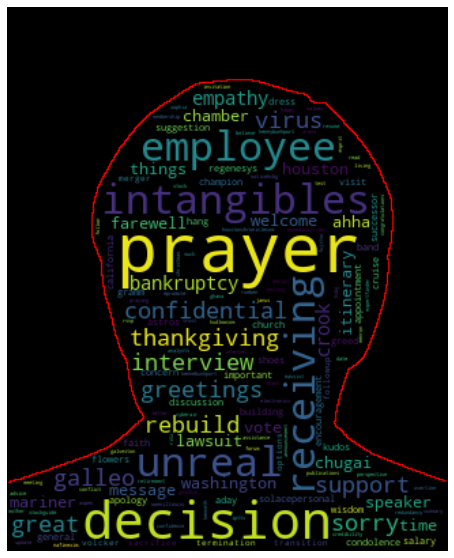

In [34]:
# word cloud of lay's email subject

# Lay's picture to be used as mask, better to have white background to work properly
mask_logo = np.array(Image.open(r'your:path\goes\here\ken_lay.png'))

wc = WordCloud(background_color = 'black', random_state = 0, min_word_length = 4, mask = mask_logo, max_words = 1000,
               contour_width=0.3, contour_color='red')

text  = ' '.join(i for i in word_df.sort_values('word_weight', ascending= False).word.values[:200])

# Remove some words
text = re.sub(r'\bansix341968qpatrioticbigecaf3f\b|'
              r'\bansix341968qenergyforummu3fozp\b|'
              r'\bansix341968qmu3fozpresentationatthebakerinstitute\b|'
              r'\bansix341968qstatementsconcerninglastweek01spricespike\b|'
              r'\b231\b|\bwhats\b|\bwebsite\b|\breply\b|\bthanks\b|\bfurniture\b|\battached\b|\bsubject\b', '', text)

wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');